In [1]:
from bs4 import BeautifulSoup
import requests
import html
import time
import argparse

In [2]:
import mygene
mg = mygene.MyGeneInfo()

In [3]:
mg.querymany("5087", scopes='entrezgene', fields='symbol', species='human')[0]['symbol']

querying 1-1...done.
Finished.


'PBX1'

In [4]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

In [5]:
expression_df=pd.read_csv('Optimal_dataset.csv')


In [6]:
GeneID=expression_df['Feature']

In [7]:
GS=mg.querymany(GeneID, scopes='entrezgene', fields='symbol', species='human')
GeneSymbol=[GS[i]['symbol'] for i in range(4998)]


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4998...done.
Finished.


In [8]:
len(set(GeneSymbol))

4998

In [9]:
expression_df['Gene ID']=GeneSymbol

In [10]:
expression_df=expression_df.drop(['Feature'], axis=1)
expression_df

,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL,Gene ID
0,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925,ADA
1,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392,CDH2
2,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776,AKT3
3,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195,ACOT8
4,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073,ABI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,9.607231,9.543961,9.677517,9.559407,9.398856,9.486502,9.366075,9.296258,9.427576,9.341100,...,7.960800,8.175102,8.625871,7.995476,8.629033,10.104216,10.150308,7.483893,7.456364,PPP4R1
4994,4.541300,4.129266,4.073877,4.563461,3.990184,3.708544,3.967550,3.958163,4.084023,3.666532,...,8.008836,7.725863,7.686385,7.747283,7.266135,6.230547,6.482698,8.156654,8.331578,SLC12A6
4995,5.560324,5.308262,5.546625,5.734750,5.004711,4.987957,5.177761,5.127617,5.182611,5.012821,...,7.023650,6.627935,7.130835,6.901606,6.811979,5.885550,6.038529,7.301287,7.535880,PTBP3
4996,5.421064,5.107210,5.445133,5.229923,5.538198,5.591131,5.475488,5.330362,5.484444,5.411318,...,6.745371,6.947689,7.349610,6.929981,6.662989,7.709261,7.385845,7.208683,7.368032,DGCR2


In [11]:
expression = expression_df.set_index("Gene ID")
expression.rename_axis(None, inplace=True)
print(expression.shape)


(4998, 2636)


In [12]:
expression.head()

,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46386.CEL,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL
ADA,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.277586,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925
CDH2,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.676218,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392
AKT3,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.441616,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776
ACOT8,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.281914,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195
ABI1,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.486721,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073


In [53]:
DATA_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/tmp"
RESOURCES_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources"
DATABASE_FOLDER = "/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/"
homoData='/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans'
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = os.path.join(homoData, "hg19-*.feather")

MOTIFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
OUT_TFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER , "mm_mgi_tfs.txt")
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")

def quantile_normalization(df):
    
    "Quantile normalization consists on sorting, averaging and re-ordering."
    "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
    # step 1/3: sorting sample values
    df_sorted = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df.rank(method="min").astype(int)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

    return df_qn

expression_qn = quantile_normalization(expression)

In [15]:
ex_matrix =expression.iloc[0:1000,0:650].T
ex_matrix

,ADA,CDH2,AKT3,ACOT8,ABI1,GNPDA1,TANK,HDAC6,PDCD6IP,SH2B3,...,CLUAP1,TBC1D9B,GGA2,WAPL,SETX,EMC1,ERP44,BLTP3B,SWAP70,RRP1B
E-GEOD-30169_GSM752709.cel,6.082276,8.910453,3.903745,5.963907,7.752008,7.375102,5.187760,5.620045,10.513556,9.541779,...,6.573587,7.366281,4.520462,7.649978,6.515985,6.636114,4.399774,4.787275,4.081858,9.582021
E-GEOD-30169_GSM752710.cel,6.296477,9.094440,3.573659,6.097107,7.465366,7.314584,4.776528,5.593111,10.304974,9.013600,...,6.666182,7.354129,4.205761,7.236840,6.086462,6.572052,4.398890,4.647383,4.041984,9.293093
E-GEOD-30169_GSM752711.cel,5.678143,9.018398,3.750108,5.790247,7.941747,7.420180,5.657152,5.238865,10.533208,9.677985,...,6.402999,7.588944,4.457085,7.652206,6.453483,6.828489,4.192564,5.212552,4.759505,9.213769
E-GEOD-30169_GSM752712.cel,5.903716,8.981716,4.090731,5.761399,7.606796,7.501158,5.115412,5.331495,10.522132,9.546220,...,6.357986,7.319048,4.479705,7.614384,6.545434,6.605899,4.566154,4.879280,4.730473,9.196321
E-GEOD-30169_GSM752713.cel,6.561618,9.903595,3.960562,6.016096,7.469340,7.443952,5.041231,5.256271,10.415659,9.294982,...,6.717917,7.687901,4.428243,7.357628,6.314089,6.659226,4.269930,4.963231,4.918917,9.350938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E-GEOD-5883_GSM114574.CEL,7.662976,5.833074,9.042264,6.946393,1.689265,8.390888,9.082136,7.328778,10.546268,9.286294,...,6.888946,7.120625,6.518616,7.523826,7.047006,6.049718,6.250524,2.042850,10.112011,6.065502
E-GEOD-5883_GSM114573.CEL,7.896101,6.469972,9.010852,6.986000,0.645307,8.139138,8.740065,7.497187,10.375422,9.290145,...,6.401865,7.319014,6.725192,7.361516,7.479432,6.419788,6.374575,3.995439,10.104440,5.762237
E-GEOD-5883_GSM114557.CEL,8.352056,7.425024,8.901005,6.501543,0.503665,8.074704,9.089723,7.028354,10.315053,9.476599,...,6.747413,6.831294,6.143261,7.495076,7.219034,6.460464,6.275990,3.838939,10.233981,6.247350
E-GEOD-5883_GSM114568.CEL,7.465667,7.783863,8.860528,6.421347,0.703109,8.421323,8.853661,7.026237,10.278883,9.703201,...,6.564240,7.420934,6.884046,7.182481,7.532366,6.746553,6.301111,3.314519,10.223778,5.525602


In [54]:
os.chdir("/Users/farhadzare/Desktop/Thesis for master/Untitled Folder")

In [55]:
ex_matrix.to_csv('OptimalwID.csv')

In [56]:
df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')
hs_tfs = df_motifs_hgnc.gene_name.unique()
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_tfs) + '\n')
len(hs_tfs)

/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_32746/794328062.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')


1839

In [57]:

OUT_TFS_HGI_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')

In [58]:
OUT_TFS_HGI_FNAME

'/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt'

In [59]:
df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')

/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_32746/1370331775.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')


In [60]:
HO_tfs = df_motifs_Hgi.gene_name.unique()
len(HO_tfs)

1839

In [61]:
with open('/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt', 'wt') as f:
    f.write('\n'.join(HO_tfs) + '\n')  


In [62]:
tf_names = load_tf_names(OUT_TFS_HGNC_FNAME)

In [63]:
len(tf_names)

1839

In [64]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [27]:
adjancencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [28]:
adjancencies.head()


,TF,target,importance
17,CEBPB,MTHFD2,114.656687
77,EZH2,OIP5,109.352722
17,CEBPB,CEBPG,105.788578
17,CEBPB,EIF1,104.668294
17,CEBPG,CEBPB,104.295467


In [65]:
adjancencies.to_csv('ADJACENCIES.csv', index=False, sep='\t')
#adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')


In [68]:
db_fnames = glob.glob(DATABASES_GLOB)
db_fnames

['/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings.feather']

In [33]:
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]

In [48]:
for i in db_fnames:
    convert_feather_v1_to_v2_vice_versa(i,i)

In [69]:
for i in db_fnames:
    print(name(i))

hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings


In [70]:
dbs = [RankingDatabase(fname=i, name=name(i)) for i in db_fnames]

In [71]:
dbs

[FeatherRankingDatabase(name="hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings")]

In [72]:
modules = list(modules_from_adjacencies(adjancencies, ex_matrix))


2022-08-10 23:33:05,779 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-08-10 23:33:05,802 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-08-10 23:33:06,377 - pyscenic.utils - INFO - Creating modules.


In [73]:
List=[]
for i in range(len(modules)):
    List.append(len(modules[i]))
    

<BarContainer object of 509 artists>

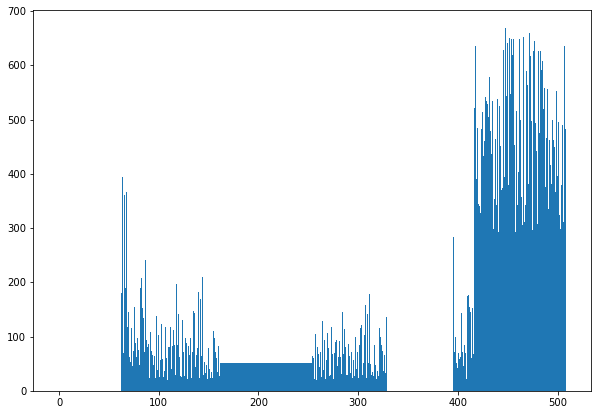

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize =(10, 7))
plt.bar(range(len(modules)), List)

In [81]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

[                                        ] | 0% Completed |  1min 18.3s


2022-08-10 23:37:09,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-08-10 23:37:09,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed |  1min 21.3s


2022-08-10 23:37:12,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed |  1min 25.1s


2022-08-10 23:37:16,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed |  1min 25.5s


2022-08-10 23:37:16,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed |  1min 32.9s


2022-08-10 23:37:24,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP2 could be mapped to hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[########################################] | 100% Completed |  5min 45.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [85]:
len(regulons)

42

In [82]:
regulons[1].name

'ATF2(+)'

In [83]:
List2=[]
List1=[]
for i in range(len(regulons)):
    List2.append(regulons[i].name)
    List1.append(len(regulons[i]))



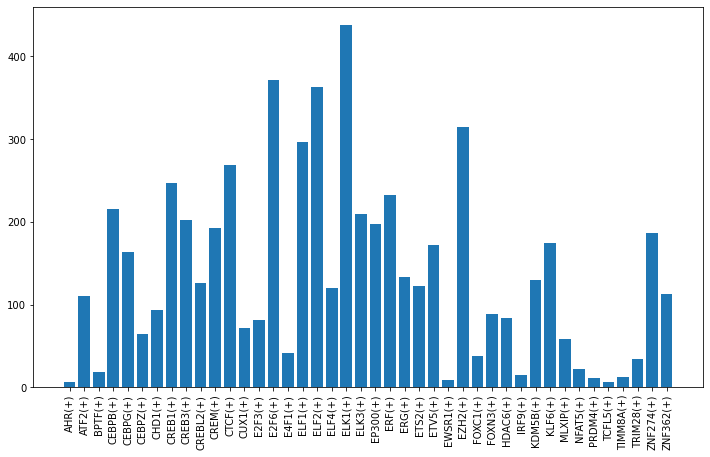

In [84]:
fig = plt.figure(figsize =(12, 7))
plt.bar(List2, List1)
plt.xticks(rotation='vertical')
plt.show()

In [86]:
# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [87]:
df = load_motifs(MOTIFS_FNAME)
with open(REGULONS_FNAME, "rb") as f:
    regulons = pickle.load(f)

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


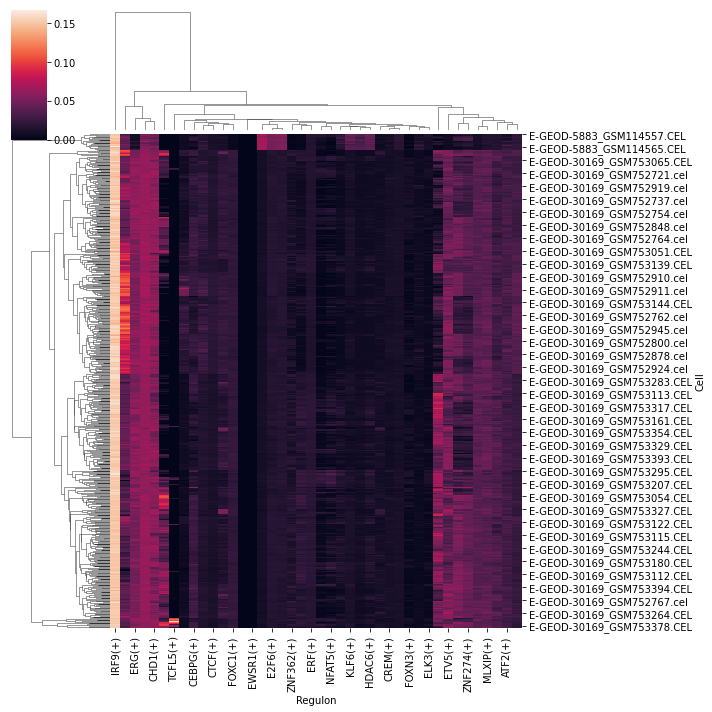

In [88]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=5)
sns.clustermap(auc_mtx, figsize=(10,10))